In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas
import numpy as np
import sqlalchemy as sa
import re
import dateutil
import pudl
import pudl.extract.ferc714
import pudl.transform.ferc714
import pathlib
import zipfile

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

In [4]:
#plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (20,8)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [5]:
import logging
import sys
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
log_format = '%(asctime)s [%(levelname)8s] %(name)s:%(lineno)s %(message)s'
formatter = logging.Formatter(log_format)
handler.setFormatter(formatter)
logger.handlers = [handler]

In [6]:
pudl_settings = pudl.workspace.setup.derive_paths(pudl_in="/home/zane/code/catalyst/pudl-work", pudl_out="/home/zane/code/catalyst/pudl-work")
ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_settings

{'pudl_in': '/home/zane/code/catalyst/pudl-work',
 'data_dir': '/home/zane/code/catalyst/pudl-work/data',
 'settings_dir': '/home/zane/code/catalyst/pudl-work/settings',
 'pudl_out': '/home/zane/code/catalyst/pudl-work',
 'sqlite_dir': '/home/zane/code/catalyst/pudl-work/sqlite',
 'parquet_dir': '/home/zane/code/catalyst/pudl-work/parquet',
 'datapkg_dir': '/home/zane/code/catalyst/pudl-work/datapkg',
 'notebook_dir': '/home/zane/code/catalyst/pudl-work/notebook',
 'ferc1_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/pudl.sqlite'}

In [24]:
%%time
raw_dfs = pudl.extract.ferc714.extract(pudl_settings=pudl_settings)

2020-04-17 20:00:42,264 [    INFO] pudl.extract.ferc714:74 Reading respondent_id_ferc714 from CSV into pandas DataFrame.
2020-04-17 20:00:42,269 [    INFO] pudl.extract.ferc714:74 Reading id_certification_ferc714 from CSV into pandas DataFrame.
2020-04-17 20:00:42,288 [    INFO] pudl.extract.ferc714:74 Reading ba_gen_plants_ferc714 from CSV into pandas DataFrame.
2020-04-17 20:00:42,462 [    INFO] pudl.extract.ferc714:74 Reading ba_demand_monthly_ferc714 from CSV into pandas DataFrame.
2020-04-17 20:00:42,498 [    INFO] pudl.extract.ferc714:74 Reading ba_net_energy_load_ferc714 from CSV into pandas DataFrame.
2020-04-17 20:00:42,537 [    INFO] pudl.extract.ferc714:74 Reading adjacent_bas_ferc714 from CSV into pandas DataFrame.
2020-04-17 20:00:42,636 [    INFO] pudl.extract.ferc714:74 Reading ba_interchange_ferc714 from CSV into pandas DataFrame.
2020-04-17 20:00:42,652 [    INFO] pudl.extract.ferc714:74 Reading ba_lambda_hourly_ferc714 from CSV into pandas DataFrame.
2020-04-17 20:00:

In [81]:
%%time
tables = (
    "respondent_id_ferc714",
    "id_certification_ferc714",
    "ba_gen_plants_ferc714",
    "ba_demand_monthly_ferc714",
    "ba_net_energy_load_ferc714",
    "adjacent_bas_ferc714",
    "ba_interchange_ferc714",
    "ba_lambda_hourly_ferc714",
    "lambda_description_ferc714",
    "pa_description_ferc714",
    "pa_demand_forecast_ferc714",
    "pa_demand_hourly_ferc714",
)
tf_dfs = pudl.transform.ferc714.transform(ferc714_raw_dfs, tables=tables)

2020-04-17 20:18:32,799 [    INFO] pudl.transform.ferc714:699 Transforming respondent_id_ferc714.
2020-04-17 20:18:32,810 [    INFO] pudl.transform.ferc714:699 Transforming id_certification_ferc714.
2020-04-17 20:18:32,810 [    INFO] pudl.transform.ferc714:652 Removing unnecssary columns and dropping test respondents.
2020-04-17 20:18:32,819 [    INFO] pudl.transform.ferc714:699 Transforming ba_gen_plants_ferc714.
2020-04-17 20:18:32,819 [    INFO] pudl.transform.ferc714:652 Removing unnecssary columns and dropping test respondents.
2020-04-17 20:18:32,842 [    INFO] pudl.transform.ferc714:699 Transforming ba_demand_monthly_ferc714.
2020-04-17 20:18:32,842 [    INFO] pudl.transform.ferc714:652 Removing unnecssary columns and dropping test respondents.
2020-04-17 20:18:32,850 [    INFO] pudl.transform.ferc714:699 Transforming ba_net_energy_load_ferc714.
2020-04-17 20:18:32,851 [    INFO] pudl.transform.ferc714:652 Removing unnecssary columns and dropping test respondents.
2020-04-17 20:

In [80]:
tf_dfs[tables[-1]]

,respondent_id,report_yr,plan_year,summer_forecast,winter_forecast,net_energy_forecast
0,2,2006,2007,1108,0,0
1,2,2006,2008,1141,0,0
2,2,2006,2009,1173,0,0
3,2,2006,2010,1261,0,0
4,2,2006,2011,1292,0,0
...,...,...,...,...,...,...
16025,240,2018,2024,3820,5196,25730000
16026,240,2018,2025,3851,5206,25800000
16027,240,2018,2026,3900,5239,25880000
16028,240,2018,2027,3941,5269,25980000


## Initial data read and processing

In [22]:
respondents_ferc714 = pudl.transform.ferc714.respondents_ferc714(pudl_settings)

In [146]:
electricity_planning_areas = pudl.transform.ferc714.electricity_planning_areas(pudl_settings)

In [27]:
%%time
all714 = pudl.transform.ferc714.planning_area_hourly_demand_ferc714(pudl_settings)

2020-04-17 12:14:04,344 [    INFO] pudl.transform.ferc714:505 Reading FERC 714 hourly demand by planning area.
2020-04-17 12:14:06,874 [    INFO] pudl.transform.ferc714:509 Removing unnecssary columns and dropping test respondents.
2020-04-17 12:14:07,006 [    INFO] pudl.transform.ferc714:517 Converting dates into pandas Datetime types.
2020-04-17 12:14:51,021 [    INFO] pudl.transform.ferc714:529 Melting daily FERC 714 records into hourly records.
2020-04-17 12:14:54,401 [    INFO] pudl.transform.ferc714:386 Found 0 duplicated hours.
2020-04-17 12:14:54,402 [    INFO] pudl.transform.ferc714:308 Standardizing UTC offset codes.
2020-04-17 12:16:56,353 [    INFO] pudl.transform.ferc714:323 Removing unfixable duplicate 25th hours.
2020-04-17 12:18:11,454 [    INFO] pudl.transform.ferc714:386 Found 110 duplicated hours.
2020-04-17 12:18:11,455 [    INFO] pudl.transform.ferc714:375 Dropping remaining 25th hour timesteps for all respondents.
2020-04-17 12:18:12,722 [    INFO] pudl.transform.

In [461]:
all714[all714.duplicated(["respondent_id", "utc_time"])]

,respondent_id,eia_code,respondent_name,utc_time,timezone,demand_mwh
13361128,101,189,PowerSouth Energy Cooperative (Alabama Electri...,2007-03-11 05:00:00,America/Chicago,680.17
13361492,101,189,PowerSouth Energy Cooperative (Alabama Electri...,2008-03-09 05:00:00,America/Chicago,1223.58
13361857,101,189,PowerSouth Energy Cooperative (Alabama Electri...,2009-03-09 05:00:00,America/Chicago,609.72
13362222,101,189,PowerSouth Energy Cooperative (Alabama Electri...,2010-03-09 05:00:00,America/Chicago,667.30
13362591,101,189,PowerSouth Energy Cooperative (Alabama Electri...,2011-03-13 05:00:00,America/Chicago,678.29
...,...,...,...,...,...,...
13933260,308,17867,City of St. Cloud,2015-03-08 04:00:00,America/New_York,49.00
13933631,308,17867,City of St. Cloud,2016-03-13 04:00:00,America/New_York,60.00
13933995,308,17867,City of St. Cloud,2017-03-12 04:00:00,America/New_York,63.00
13940934,329,<NA>,East Texas Electric Cooperative,2017-03-12 05:00:00,America/Chicago,303.00


In [462]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine)

In [465]:
utils_eia860 = pudl_out.utils_eia860()
plants_eia860 = pudl_out.plants_eia860()

In [466]:
plants_eia860.sample(10)

,plant_id_eia,plant_name_eia,balancing_authority_code,balancing_authority_name,city,county,ferc_cogen_status,ferc_exempt_wholesale_generator,ferc_small_power_producer,grid_voltage_kv,grid_voltage_2_kv,grid_voltage_3_kv,iso_rto_code,latitude,longitude,nerc_region,primary_purpose_naics_id,sector_name,sector_id,state,street_address,zip_code,timezone,report_date,ash_impoundment,ash_impoundment_lined,ash_impoundment_status,energy_storage,ferc_cogen_docket_no,ferc_exempt_wholesale_generator_docket_no,ferc_small_power_producer_docket_no,liquefied_natural_gas_storage,natural_gas_local_distribution_company,natural_gas_storage,natural_gas_pipeline_name_1,natural_gas_pipeline_name_2,natural_gas_pipeline_name_3,net_metering,pipeline_notes,regulatory_status_code,transmission_distribution_owner_id,transmission_distribution_owner_name,transmission_distribution_owner_state,utility_id_eia,water_source,plant_id_pudl,utility_id_pudl
24254,6791,Augusta Electric Plant No 2,SWPP,Southwest Power Pool,Augusta,None,False,False,False,12.47,NaN,NaN,SPP,NaN,NaN,SPP,22.0,Electric Utility,1.0,KS,615 E 12th Street,67010.0,US/Central,2012-01-01,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,RE,998,City of Augusta,KS,998,Municipality,2701,914
5892,905,Alamo,CISO,California Independent System Operator,Pearblossom,Los Angeles,False,False,False,66.00,NaN,NaN,CAISO,34.815800,-118.686700,WECC,22.0,Electric Utility,1.0,CA,34534 116 St. E. P.O Box 1187,93553.0,America/Los_Angeles,2012-01-01,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,RE,17609,Southern California Edison Co,CA,3255,Water From Penstocks Ca Aquedu,1622,743
3424,493,George Birdsall,WACM,Western Area Power Administration - Rocky Moun...,Colorado Springs,El Paso,False,False,False,34.50,NaN,NaN,None,38.881389,-104.816944,WECC,22.0,Electric Utility,1.0,CO,213 Nichols Blvd.,80907.0,America/Denver,2016-01-01,False,False,None,False,None,None,None,False,COLORADO SPRINGS UTILITIES,False,Other - Please explain in pipeline notes below.,None,None,None,This plant is connected to the LDC of Colorado...,RE,3989,City of Colorado Springs - (CO),CO,3989,Municipality,1490,956
18480,3646,None,PACE,PacifiCorp - East,Collinston,Box Elder,False,False,False,46.00,NaN,NaN,None,41.834702,-112.052114,WECC,22.0,Electric Utility,1.0,UT,1365 W Cutler Dam Road,84306.0,America/Denver,2014-01-01,None,False,None,None,None,None,None,None,None,None,None,None,None,None,None,RE,14354,PacifiCorp,OR,14354,Bear River,1011,246
77279,59780,New Bedford (MA) Plymouth,ISNE,ISO New England Inc.,Plymouth,Plymouth,False,False,True,23.00,NaN,NaN,None,41.925352,-70.649029,NPCC,22.0,IPP Non-CHP,2.0,MA,30 Raffaele Road,2360.0,America/New_York,2016-01-01,False,None,None,False,None,None,14-559-000,None,None,None,None,None,None,None,None,NR,54913,NSTAR Electric Company,MA,59545,None,7422,733
10722,1932,West Fairbault,None,None,Faribault,Rice,False,False,False,NaN,NaN,NaN,MISO,44.269722,-93.290556,MRO,22.0,Electric Utility,1.0,MN,17th St. SW,55021.0,America/Chicago,2015-01-01,False,False,None,None,None,None,None,None,None,None,NSPM LDC,None,None,None,None,RE,None,None,None,13781,None,8325,224
19433,3878,Yelm,BPAT,Bonneville Power Administration,Yelm,Thurston,False,False,False,69.00,NaN,NaN,None,46.974912,-122.635795,WECC,22.0,Electric Utility,1.0,WA,14024 Yelm Hwy. S. E.,98597.0,America/Los_Angeles,2013-01-01,False,None,None,None,None,None,None,None,None,None,None,None,None,None,None,RE,3295,City of Centralia,WA,3295,Nisqually River,2432,947
46711,55295,None,CISO,California Independent System Operator,None,Riverside,False,True,False,230.00,NaN,NaN,None,33.615700,-114.686500,WECC,22.0,IPP Non-CHP,2.0,CA,None,92225.0,America/Los_Angeles,2018-01-01,False,False,None,False,None,02-30-000,None,False,SOUTHERN CALIFORNIA GAS COMPANY,False,None,None,None,None,None,NR,17609,Southern California Edison Co,CA,58453,Wells,4494,454
78650,60076,Palmer Landfill,ISNE,ISO New England Inc.,Palmer,Hampden,False,False,False

In [464]:
utils_eia860.sample(10)

,report_date,utility_id_eia,utility_id_pudl,utility_name_eia,city,entity_type,plants_reported_asset_manager,plants_reported_operator,plants_reported_other_relationship,plants_reported_owner,state,street_address,zip_code
10160,2013-01-01,10606,1059,City of Lake Mills,Lake Mills,M,True,True,True,True,IA,201 S Mill,50450
34917,2013-01-01,57409,723,Buffalo Center Wind LLC,Waukon,Q,True,True,True,True,IA,401 8th Street SW,52172
35246,2012-01-01,57482,4988,Sandy Ridge Wind Energy LLC,"Oakville, ON L6H 7H7",None,None,None,None,None,ON,None,None
21630,2009-01-01,22822,<NA>,Clark County Rural E M C,Sellerburg,None,None,None,None,None,IN,P O Box L,47172
42900,2017-01-01,60702,<NA>,"Delco Farm, LLC",Chapell Hill,COM,None,True,None,None,NC,50101 Governors Drive Suite 28,27517
29831,2016-01-01,56397,2148,J&A-Santa Maria II LLC,Costa Mesa,Q,None,None,None,True,CA,248 Hill Place,92627
1033,2009-01-01,902,<NA>,Town of Ashburnham,Ashburnham,None,None,None,None,None,MA,None,01430
18616,2014-01-01,18947,1224,None,Tipton,M,None,True,None,True,IA,407 Lynn Street,52772
22621,2011-01-01,30150,817,None,Yakutat,M,None,None,None,None,AK,1 Forest Hwy,99689
4633,2013-01-01,4604,964,City of Crystal Falls,Crystal Falls,M,True,True,True,True,MI,401 Superior Ave,49920


# Remaining Tasks

## Find broken data:
* Run Tyler Ruggles' anomaly detection code as improved by Greg Schivley

## Repair data:
* How do we want to fill in the gaps? How many gaps are there?
* What kind of anomalies are we finding? Are they a problem?
* Has the DST/Timezone munging resulted in any discontinuities?

# Plot Demand by Planning Area

In [443]:
def plot_demand_tz(df, respondent_ids, time_col="local_time", tz_col="utc_offset_code"):
    for rid in respondent_ids:
        tz_dude = df.query("respondent_id==@rid")
        if len(tz_dude) > 0:
            sns.scatterplot(x=time_col, y="demand_mwh", data=tz_dude, hue=tz_col, edgecolor=None, s=1)
            plt.title(f"{tz_dude.respondent_name.iloc[0]} (respondent_id: {rid})")
            for sf in pudl.transform.ferc714.spring_forward:
                plt.axvline(pd.Timestamp(sf), color="green")
            for fb in pudl.transform.ferc714.fall_back:
                plt.axvline(pd.Timestamp(fb), color="red")
            plt.xlim((
                tz_dude[time_col].min(),
                tz_dude[time_col].max(),
            ))
            plt.show();

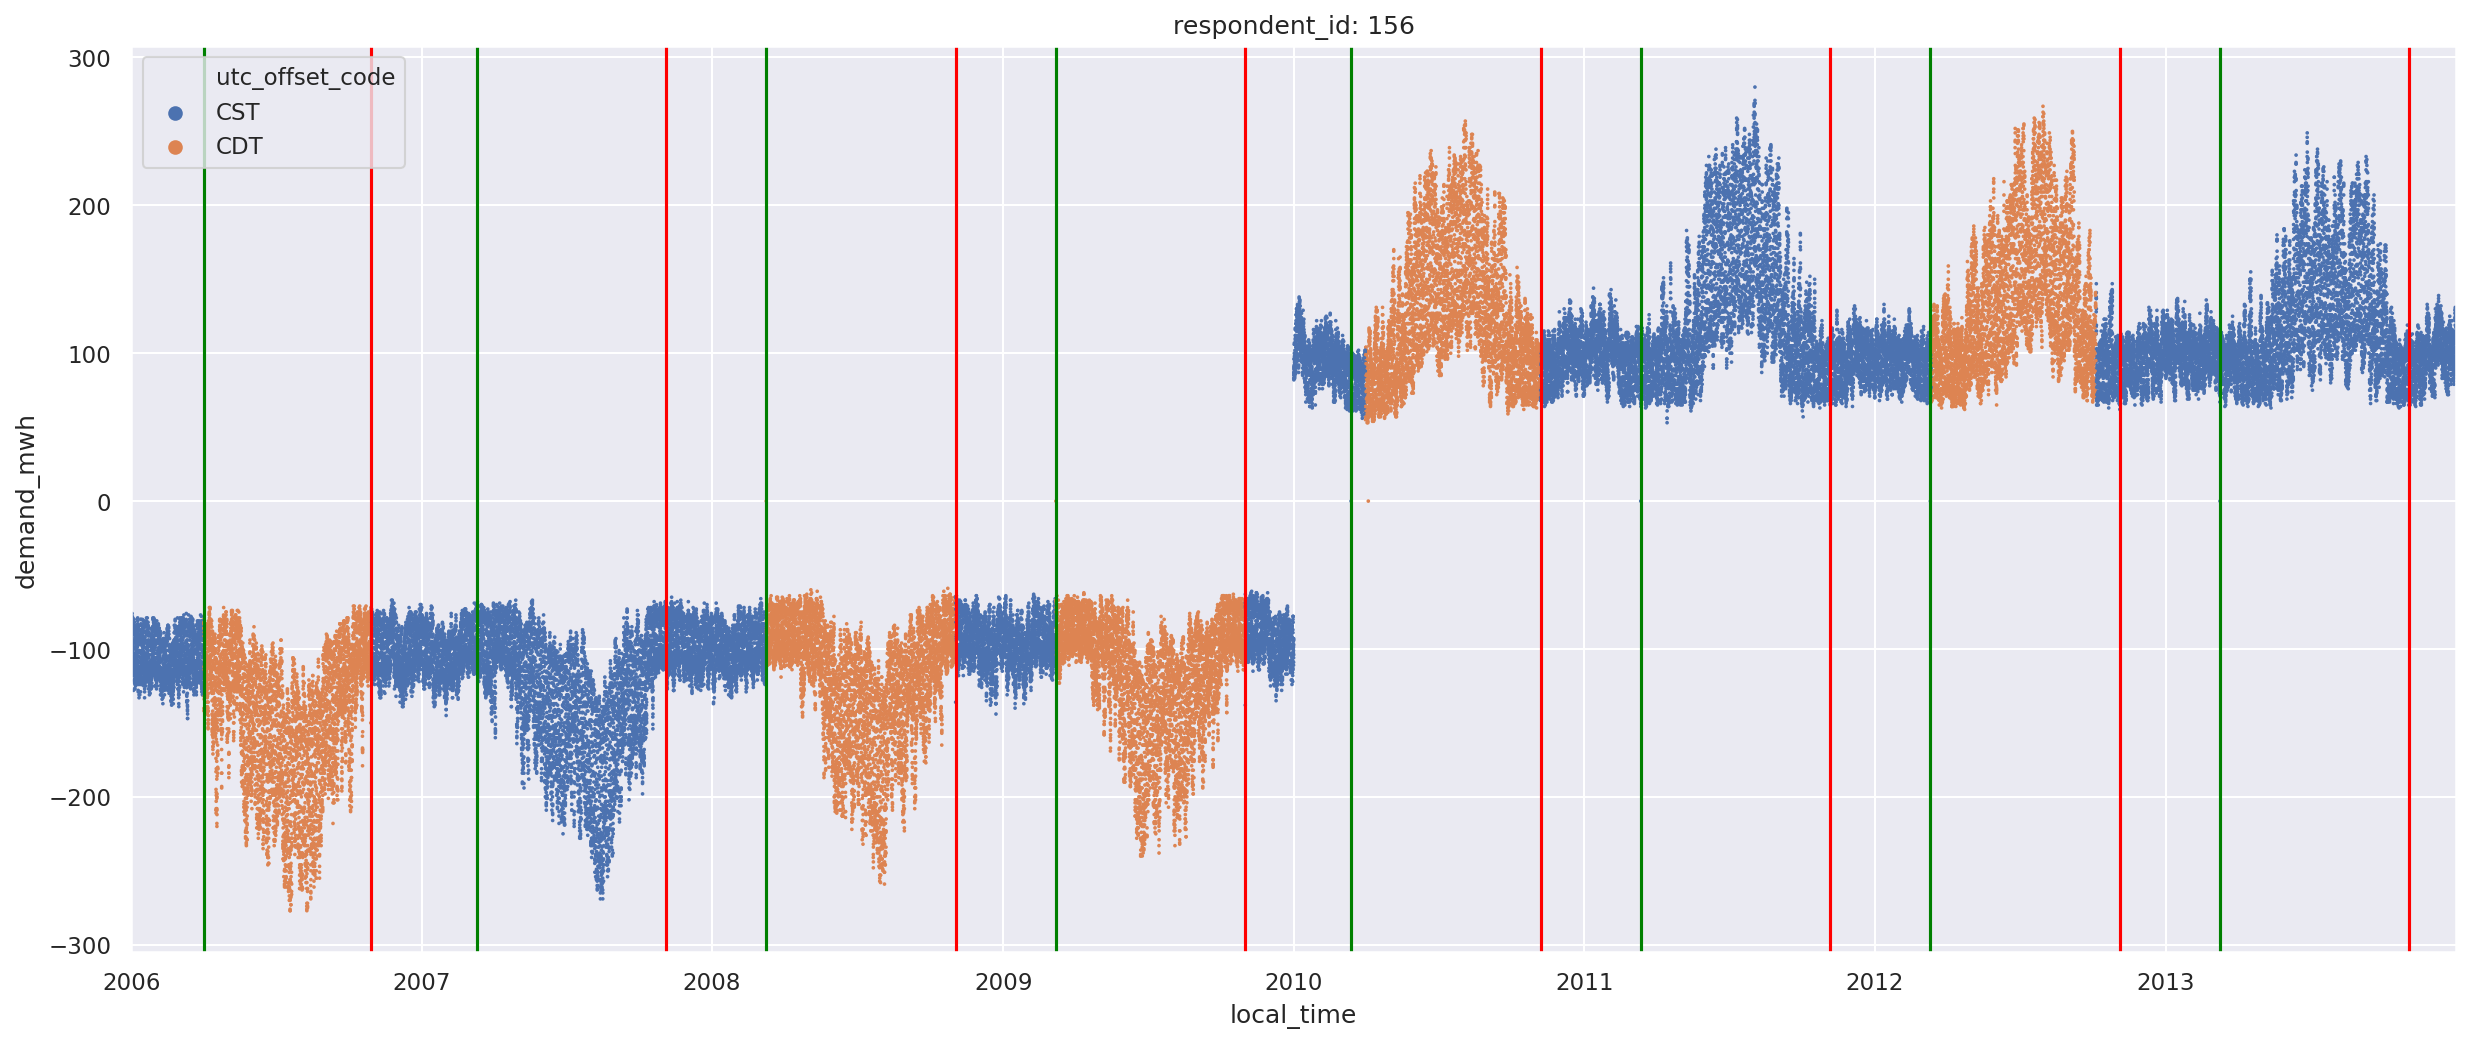

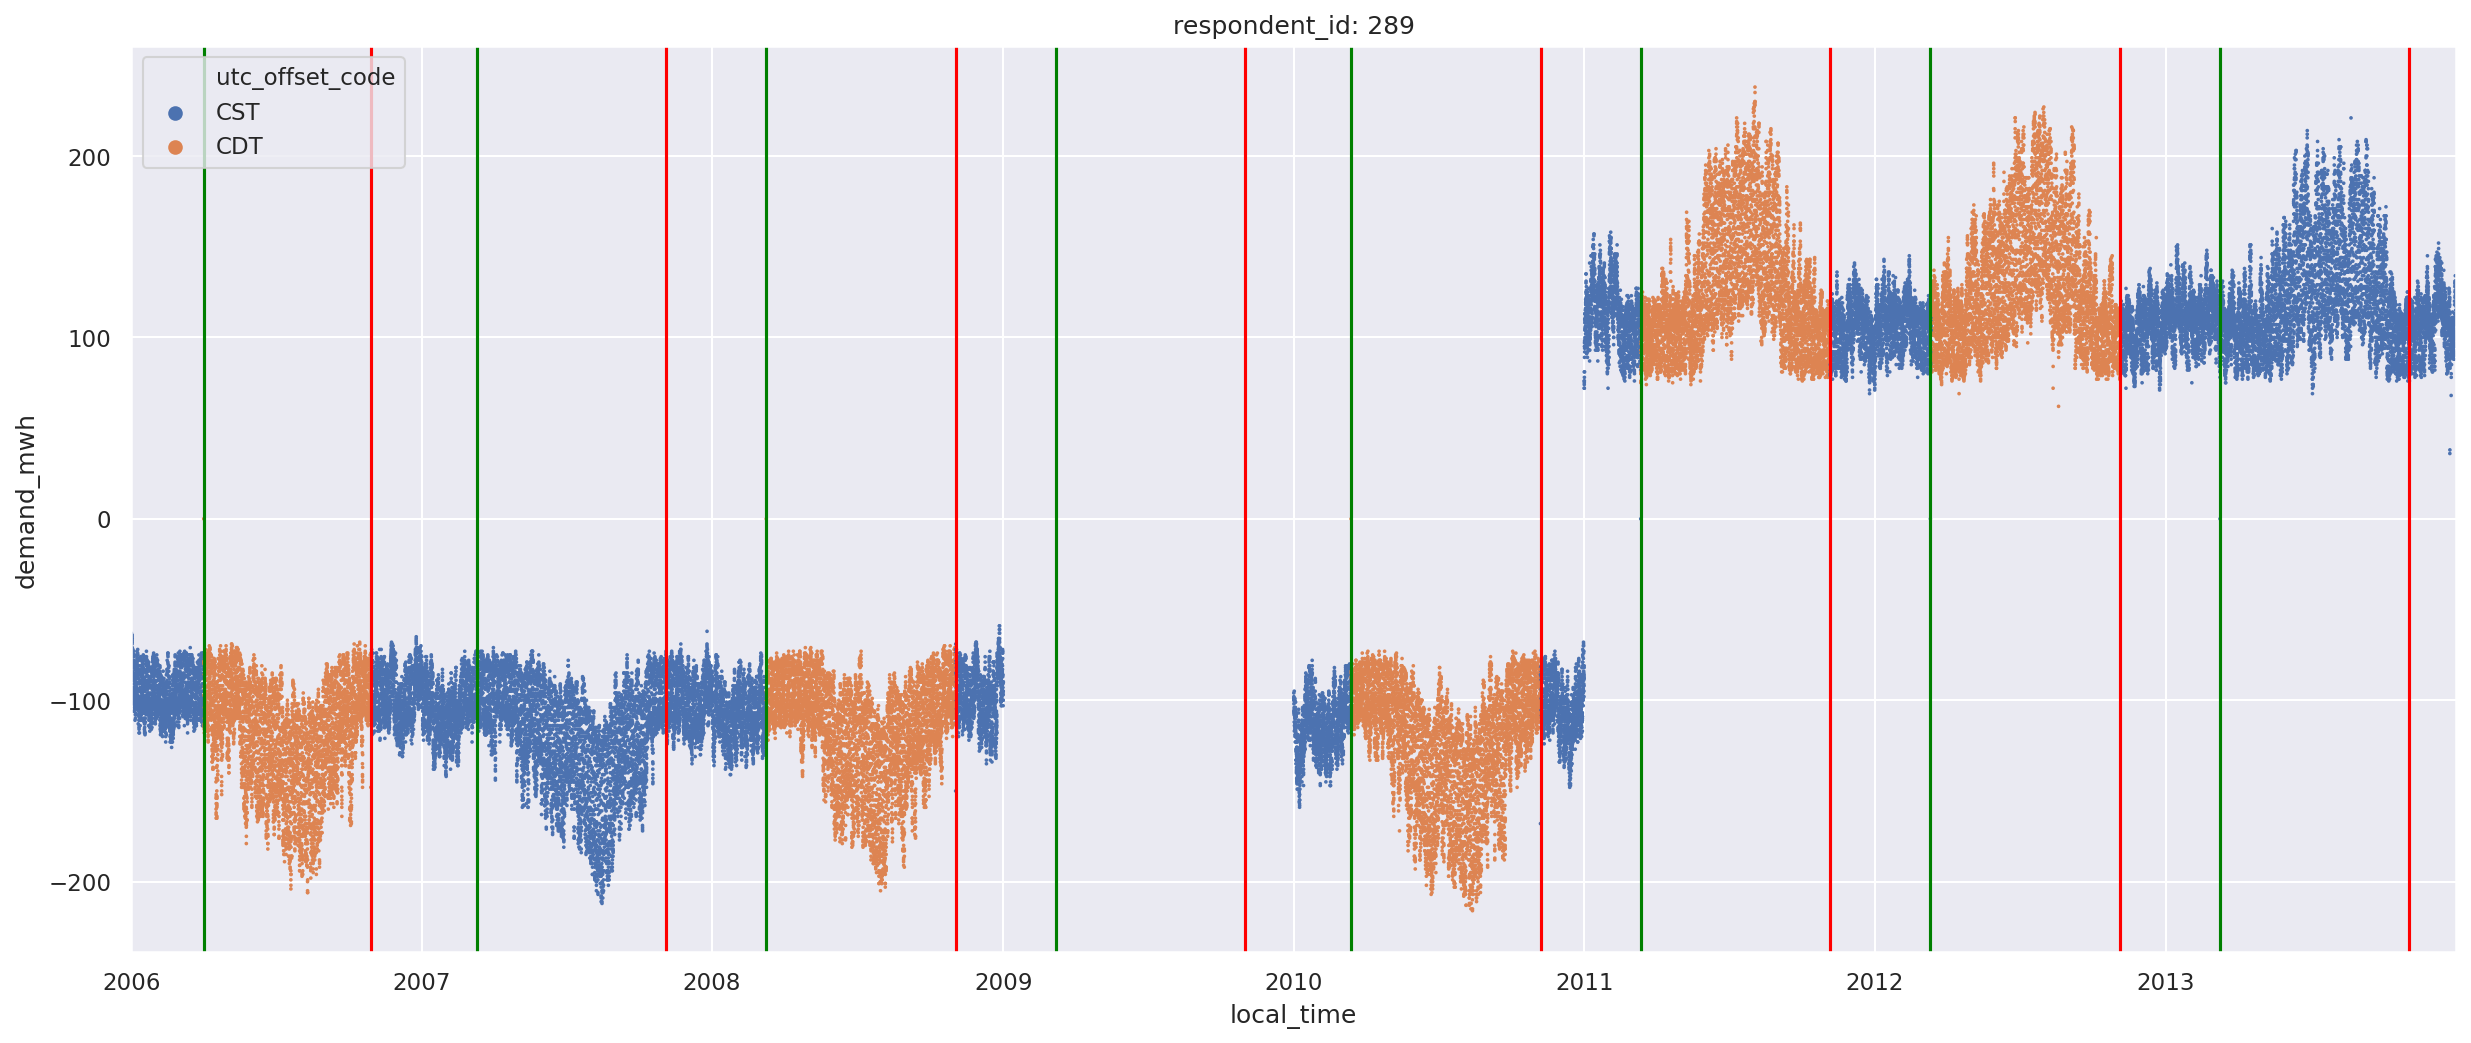

In [441]:
plot_demand_tz(dude, dude.respondent_id.unique(), time_col="local_time", tz_col="utc_offset_code")

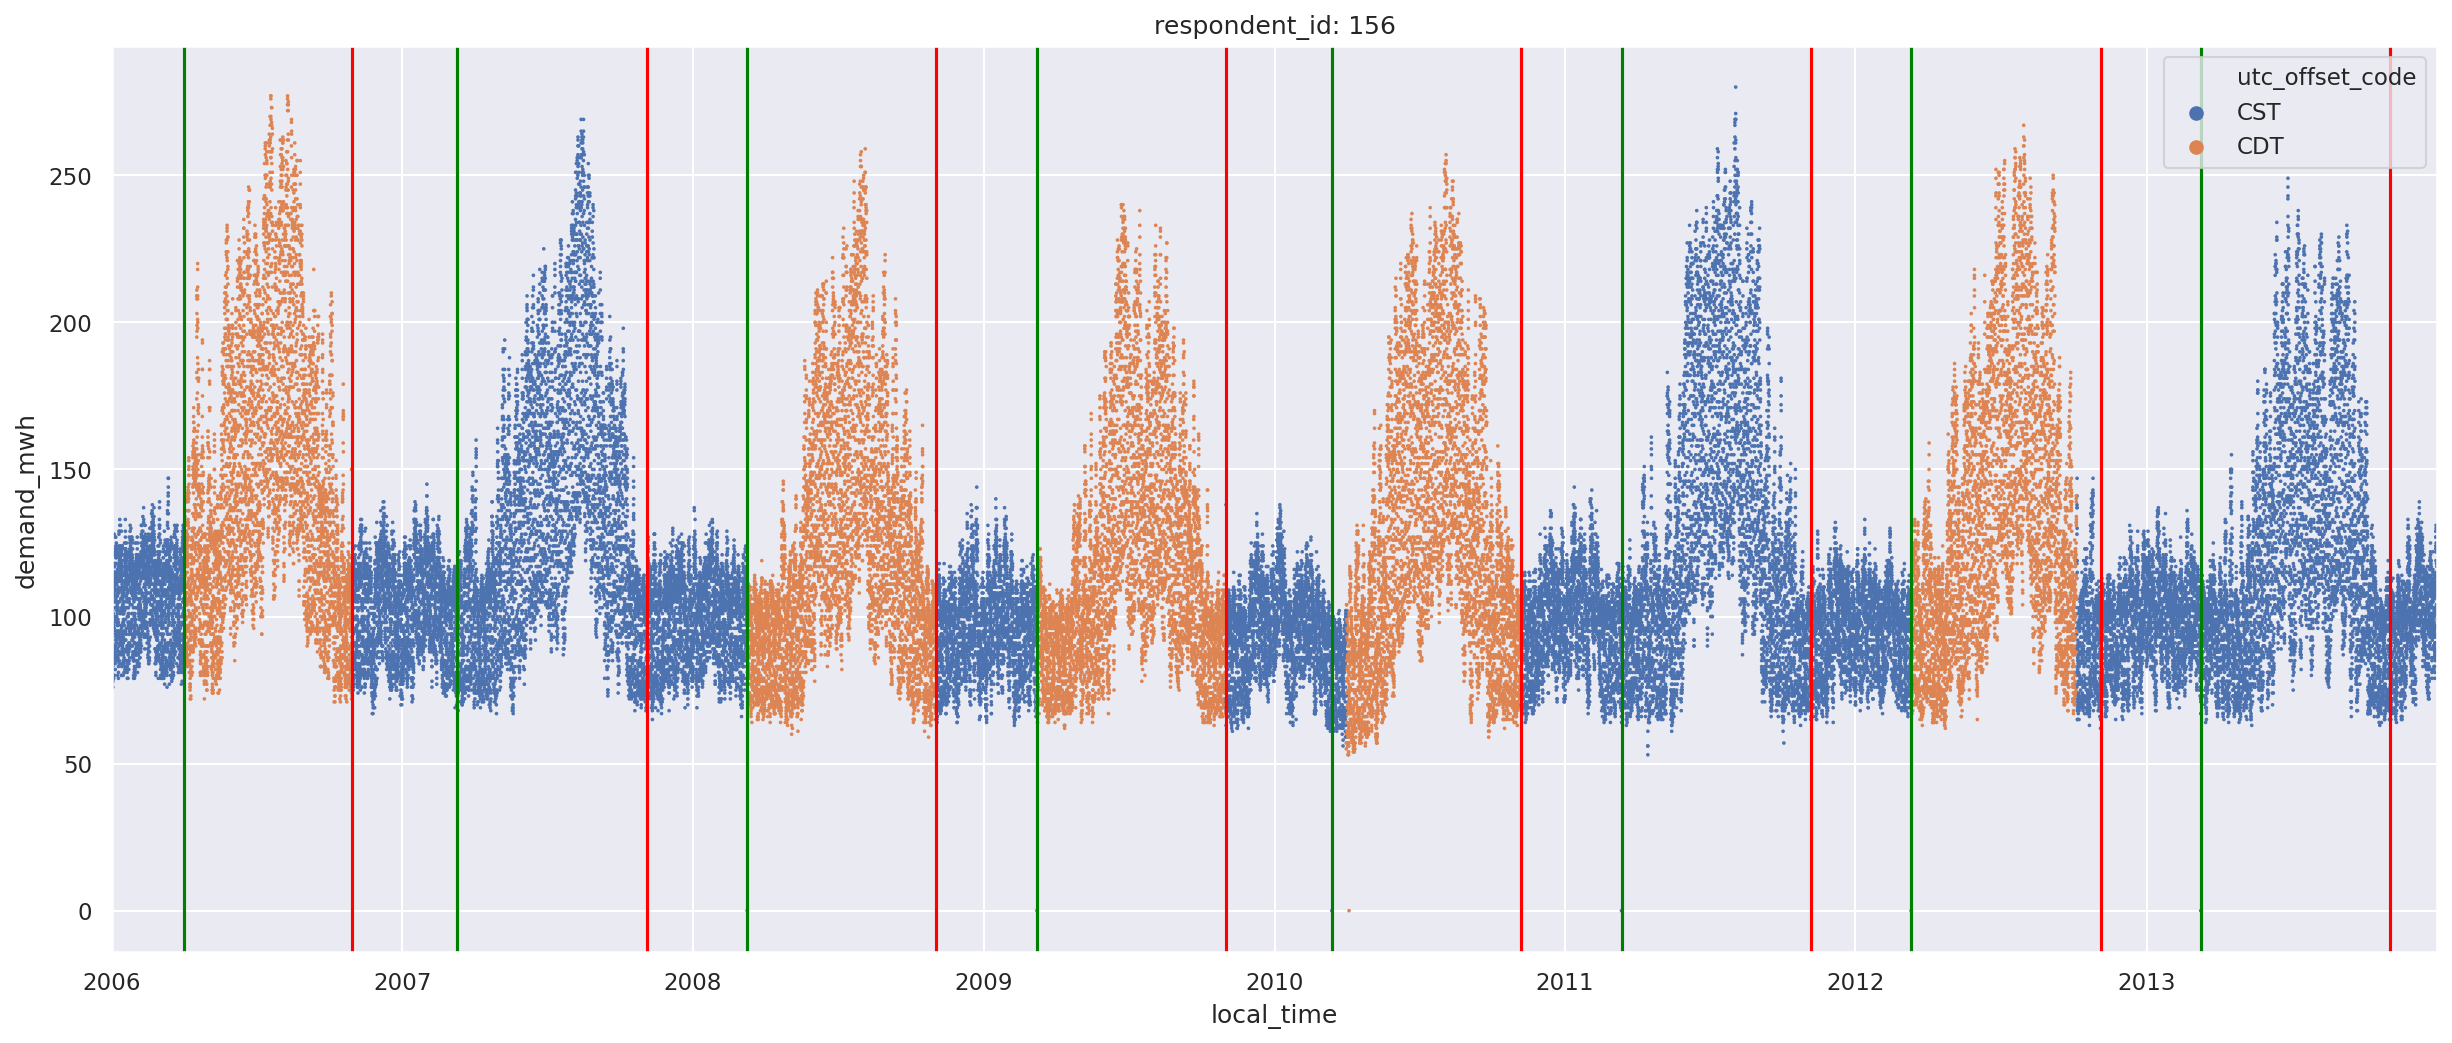

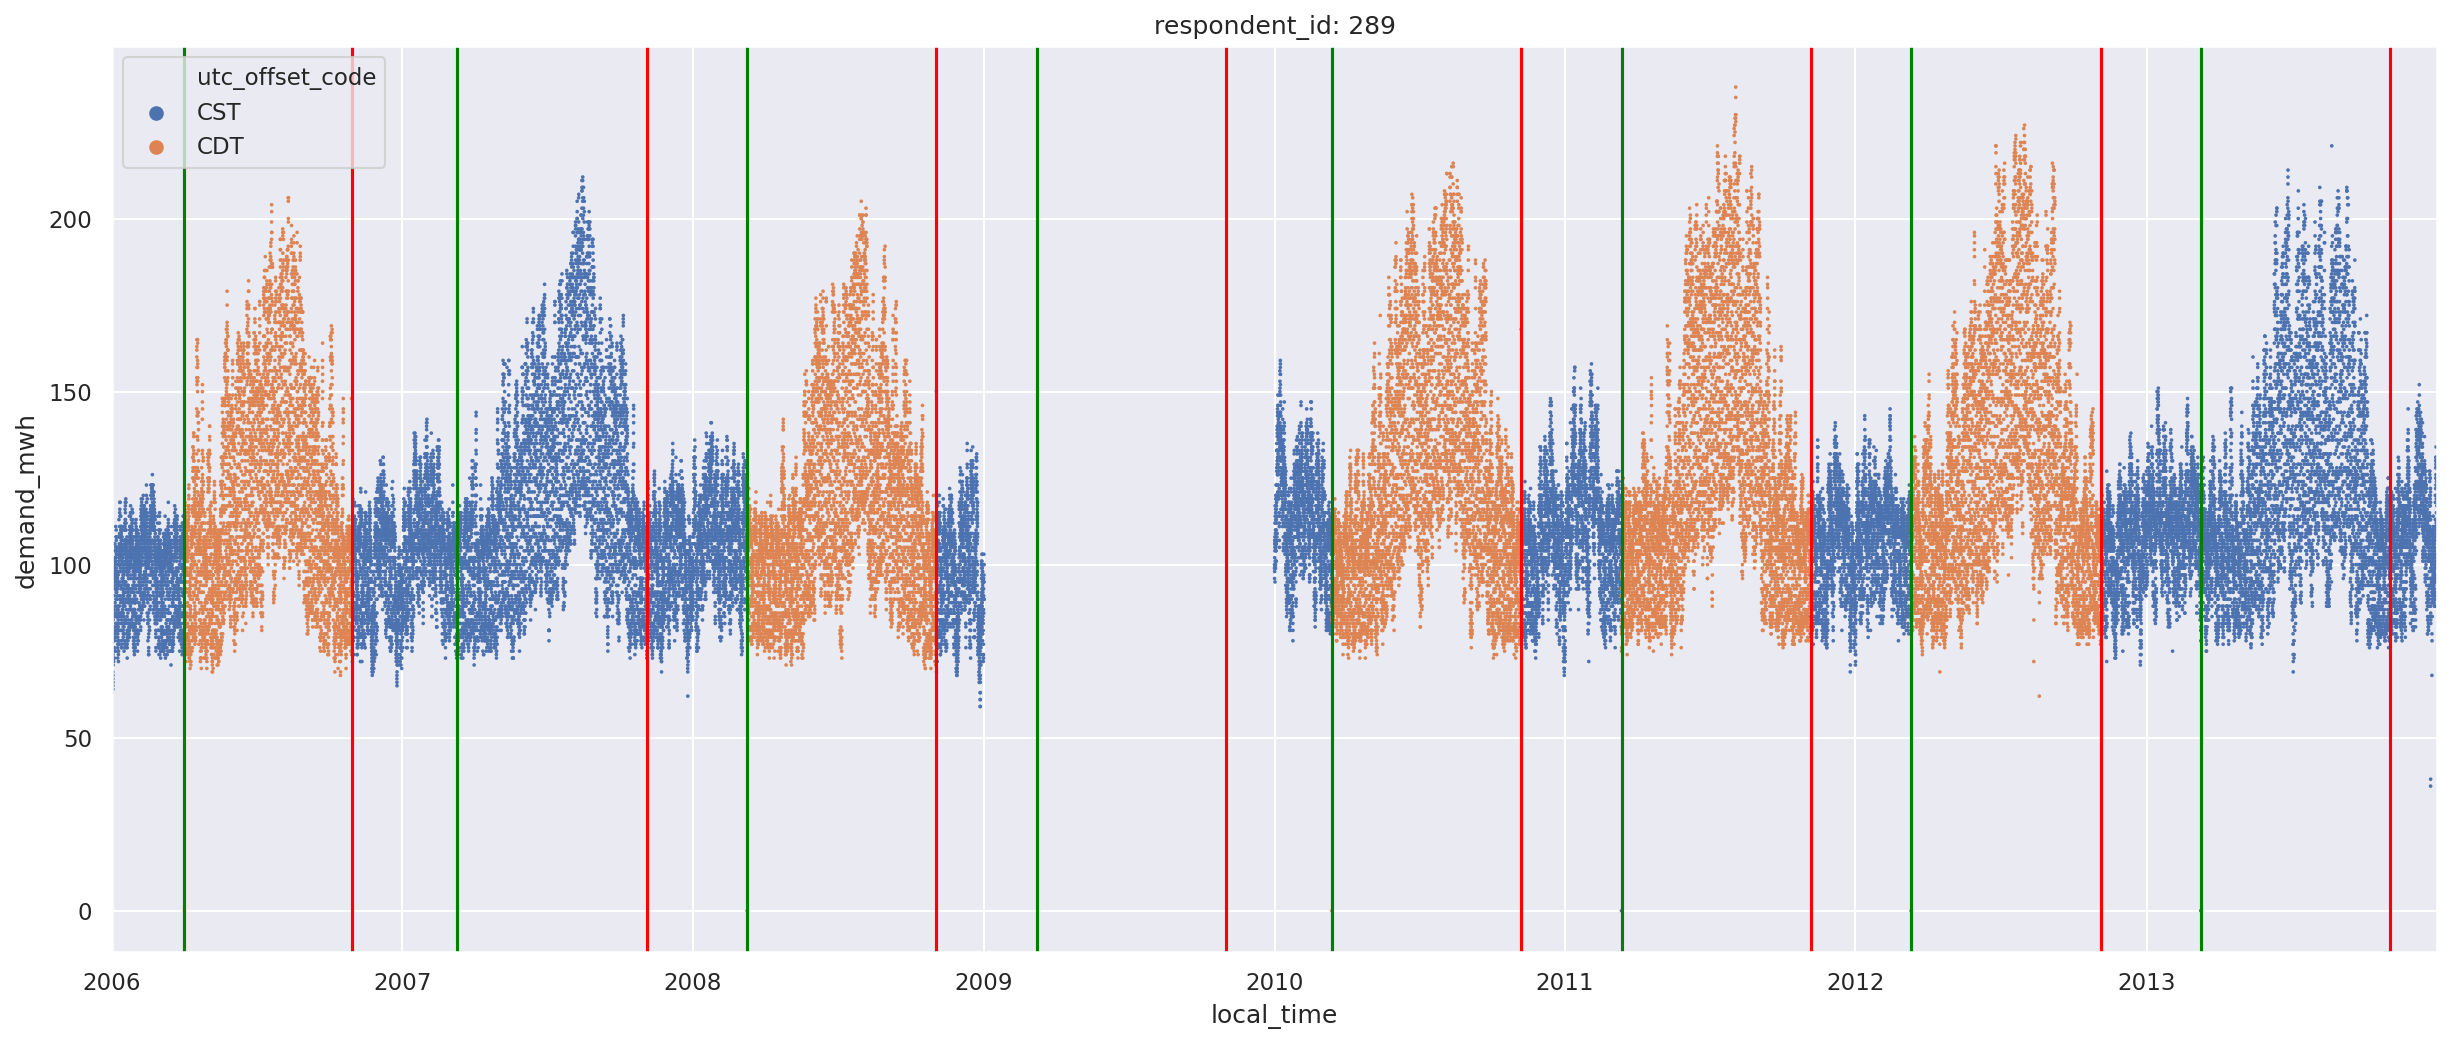

In [442]:
plot_demand_tz(dude_flipped, dude_flipped.respondent_id.unique(), time_col="local_time", tz_col="utc_offset_code")

# Missing EIA IDs

In [11]:
respondents_ferc714[respondents_ferc714.eia_code.isnull()]

,respondent_id,respondent_name,eia_code
181,295,"Old Dominion Elec. Coop., Inc.-Delmarva P&L Pl...",<NA>
187,301,PJM Interconnection Eastern Hub,<NA>
188,302,PJM Interconnection Western Hub,<NA>
189,303,PJM Interconnection Illinois Hub,<NA>
190,304,PJM Interconnection North Illinois Hub,<NA>
191,305,PJM Interconnection Dominion Hub,<NA>
192,306,PJM Interconnection AEP-Dayton Hub,<NA>
193,307,PacifiCorp - Part II Sch 2 (East & West combined),<NA>
195,309,Michigan Electric Powr Coor. Center - Detroit,<NA>
198,312,Glacier Wind Balancing Authority,<NA>


# Notes on irregularities and special cases
Unusual issues that need to be addressed, or demand discontinuities that may be useful in the context of aggregating historical demand into modern planning areas.
* Missing demand data / weird zeroes
  * 111: (2008)
  * 125: (2015)
  * 137: (2006)
  * 139: (2006) Only the last hour of every day. Maybe 0-23 vs 1-24 reporting?
  * 141: (2006, 2007, 2008, 2009, 2010)
  * 148: (2006)
  * 153: (2006)
  * 154: (2006)
  * 161: (all)
  * 183: (2007, 2009)
  * 208: (2008)
  * 273: (2007, 2008)
  * 283: (2007)
  * 287: (2008-2012)
  * 288: (2006)
  * 289: (2009)
  * 293: (2006)
  * 294: (2006)
  * 311: (2008-2011)
* Inverted Demand (Sign Errors):
  * 156: (2006, 2007, 2008, 2009)
  * 289: (2006-2008, 2010)
* Large demand discontinuities
  * 107: Demand triples at end of 2006.
  * 115: Two big step downs, 2007-2008, and 2011-2012
  * 121: 50% increase at end of 2007.
  * 128: Step up at end of 2007
  * 133: Step down end of 2013 and again end of 2015
  * 190: Demand doubled at end of 2008
  * 214: 50% jump in early 2012.
  * 256: big jump at end of 2006.
  * 261: Big jump at end of 2008.
  * 274: drop at end of 2007
  * 275: Jump at end of 2007
  * 287: Demand before and after big gap are very different.
  * 299: Big drop at end of 2015
  * 307: Jump at end of 2014
  * 321: Jump at end of 2013